In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import mean_squared_error

In [5]:
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [50]:
time_series = pd.read_csv("GoogleStocks.csv", parse_dates=True)
time_series = time_series.drop(time_series.index[0])

In [51]:
time_series.head()

,date,close,volume,open,high,low
1,2019/03/25,1193.00,1493841.0,1196.93,1206.3975,1187.040
2,2019/03/22,1205.50,1668910.0,1226.32,1230.0000,1202.825
3,2019/03/21,1231.54,1195899.0,1216.00,1231.7900,1213.150
4,2019/03/20,1223.97,2089367.0,1197.35,1227.1400,1196.170
5,2019/03/19,1198.85,1404863.0,1188.81,1200.0000,1185.870


In [52]:
time_series['high'] = pd.to_numeric(time_series['high'])
time_series['low'] = pd.to_numeric(time_series['low'])
time_series['average'] = (time_series['high'] + time_series['low']) / 2
time_series = time_series.sort_values('date')
time_series.head()

,date,close,volume,open,high,low,average
754,2016/03/28,733.53,1300817.0,736.79,738.99,732.50,735.745
753,2016/03/29,744.77,1902254.0,734.59,747.25,728.76,738.005
752,2016/03/30,750.53,1782278.0,750.10,757.88,748.74,753.310
751,2016/03/31,744.95,1718638.0,749.25,750.85,740.94,745.895
750,2016/04/01,749.91,1576240.0,738.60,750.34,737.00,743.670


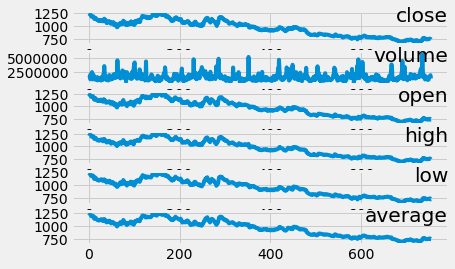

In [53]:
columns = list(time_series.columns.values)
del columns[0]
fig = plt.figure()
plt.style.use('fivethirtyeight')
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    plt.plot(time_series.index, time_series[column])
    plt.title(column, y=0.5, loc='right')
plt.show()

In [11]:
time_series.isna().any()
data = time_series[['open', 'average', 'volume']]
# Feature Scaling Normalization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
def create_dataset(data, time_stamp):
    X_train = []
    y_train = []
    print("Time stamp: {0}".format(time_stamp))
    for i in range(time_stamp, len(data)):
        X_train.append(
            np.array([data[i - time_stamp:i, 1], data[i - time_stamp:i, 2]]).T)
        y_train.append(data[i, 0])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train[:-100], y_train[:-100], X_train[-100:], y_train[-100:]

In [0]:
def create_model(number_of_layer, number_of_cells, input_shape):
    model = Sequential()
    model.add(
        LSTM(
            units=number_of_cells,
            return_sequences=True,
            input_shape=input_shape))
    input_shape = None
    model.add(Dropout(0.2))
    for l in range(number_of_layer - 1):
        return_sequence = True
        if (l == number_of_layer - 2):
            return_sequence = False
        model.add(
            LSTM(units=number_of_cells, return_sequences=return_sequence))
        model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [0]:
def run_model(data, number_of_layer, number_of_cells, time_stamp):
    X_train, y_train, X_test, y_test = create_dataset(data, time_stamp)
    print("X train shape: {0}, y_train shape: {1}".format(
        X_train.shape, y_train.shape))
    model = create_model(number_of_layer, number_of_cells, (time_stamp, 2))
    print(model.summary())
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=False)
    predicted_open_price = model.predict(X_test)
    print(
        "Number of layer: {0}, Number of cells: {1}, time_stamp: {2}, Mean square error :{3}"
        .format(number_of_layer, number_of_cells, time_stamp,
                mean_squared_error(predicted_open_price, y_test)))
    plt.plot(
        range(1, 1 + len(predicted_open_price)),
        predicted_open_price,
        label="predicted price")
    plt.plot(
        range(1, 1 + len(predicted_open_price)),
        y_test,
        label="original price")
    plt.legend(loc="best")
    plt.show()
    return predicted_open_price

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 30)            3960      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 30, time_stamp: 20, Mean squar

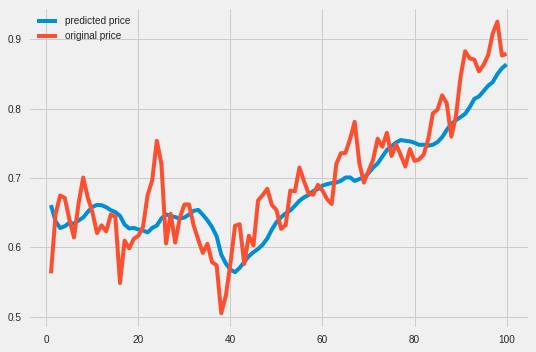

In [0]:
run_model(training_set_scaled, 2, 30, 20)

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 30)            3960      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 30, time_stamp: 20, Mean squar

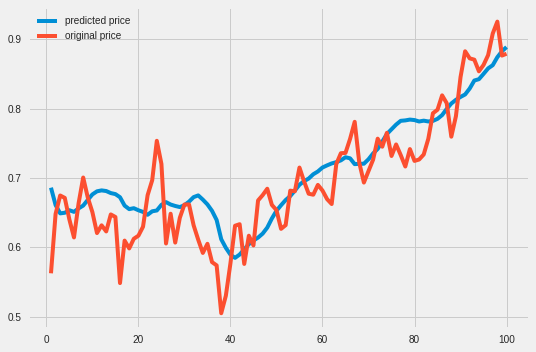

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 30, time_stamp: 50, Mean squar

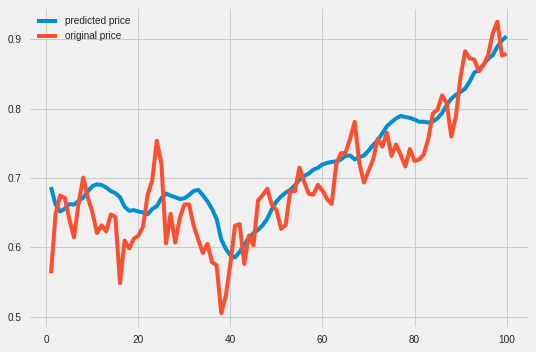

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 75, 30)            3960      
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 30)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 30, time_stamp: 75, Mean squar

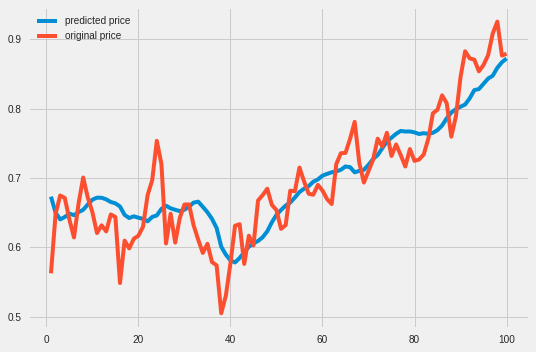

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 20, 50)            10600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 50, time_stamp: 20, Mean squar

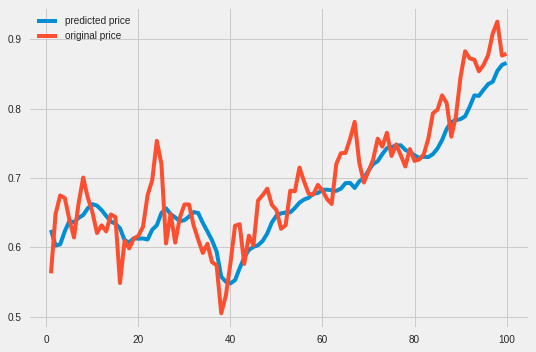

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 50)            10600     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 50, time_stamp: 50, Mean squar

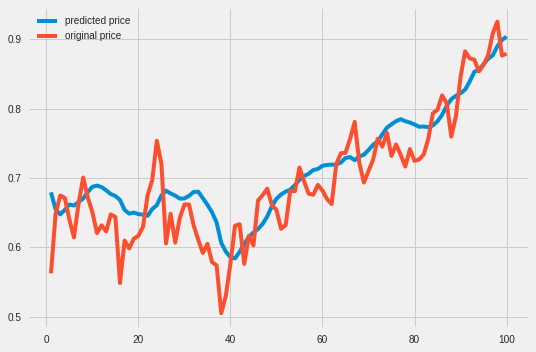

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 75, 50)            10600     
_________________________________________________________________
dropout_15 (Dropout)         (None, 75, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 50, time_stamp: 75, Mean squar

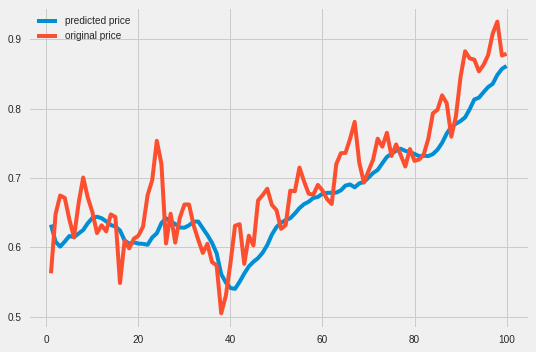

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 20, 80)            26560     
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 80)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_18 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 81        
Total params: 78,161
Trainable params: 78,161
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 80, time_stamp: 20, Mean squar

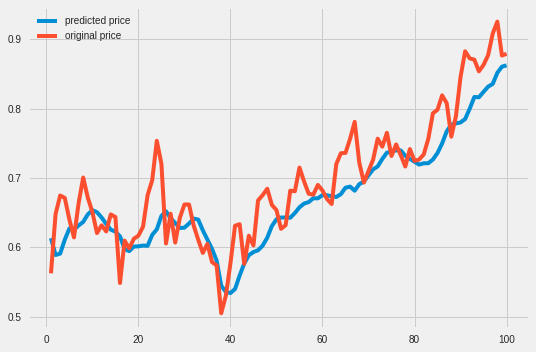

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50, 80)            26560     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_20 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 81        
Total params: 78,161
Trainable params: 78,161
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 80, time_stamp: 50, Mean squar

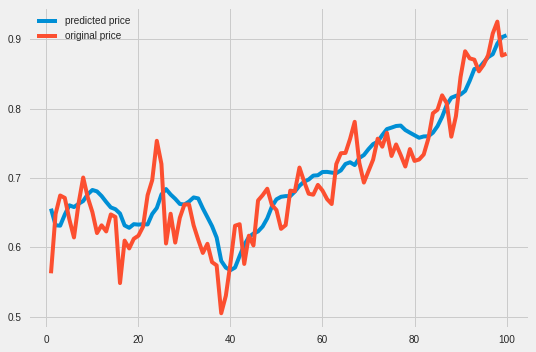

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 75, 80)            26560     
_________________________________________________________________
dropout_21 (Dropout)         (None, 75, 80)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_22 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 81        
Total params: 78,161
Trainable params: 78,161
Non-trainable params: 0
_________________________________________________________________
None
Number of layer: 2, Number of cells: 80, time_stamp: 75, Mean squar

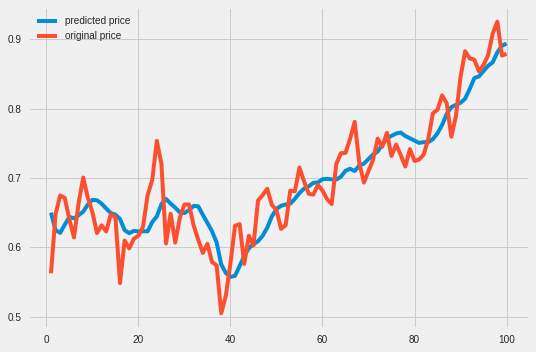

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 20, 30)            3960      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 30)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 20, 30)            7320      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 30)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_25 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_12 (

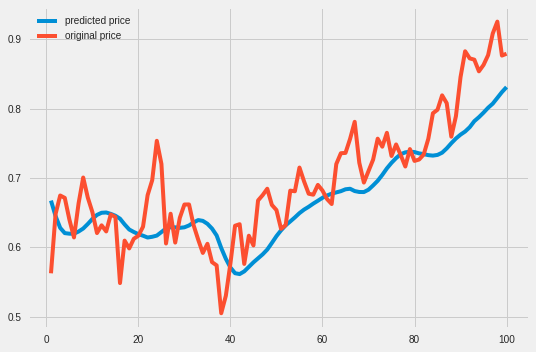

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50, 30)            3960      
_________________________________________________________________
dropout_26 (Dropout)         (None, 50, 30)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 50, 30)            7320      
_________________________________________________________________
dropout_27 (Dropout)         (None, 50, 30)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_28 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_13 (

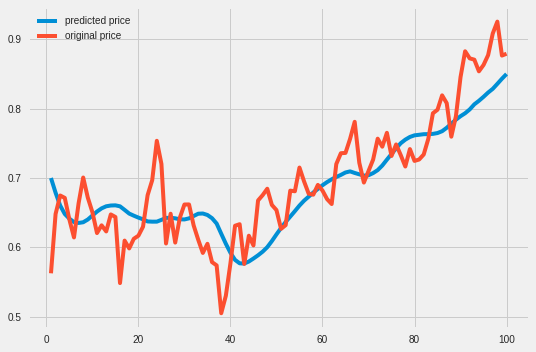

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 75, 30)            3960      
_________________________________________________________________
dropout_29 (Dropout)         (None, 75, 30)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 75, 30)            7320      
_________________________________________________________________
dropout_30 (Dropout)         (None, 75, 30)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_14 (

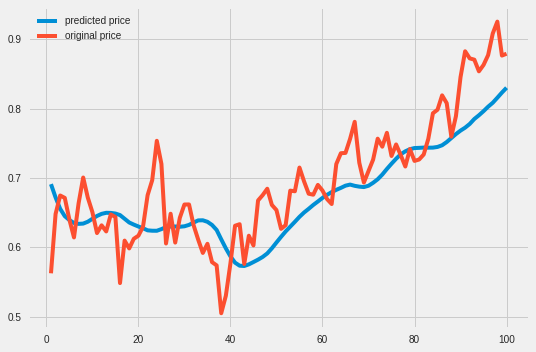

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 20, 50)            10600     
_________________________________________________________________
dropout_32 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_33 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (

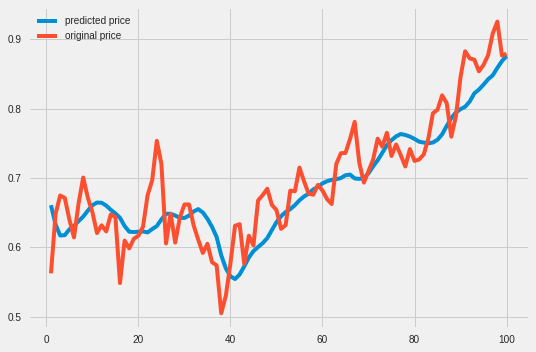

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 50, 50)            10600     
_________________________________________________________________
dropout_35 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_36 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (

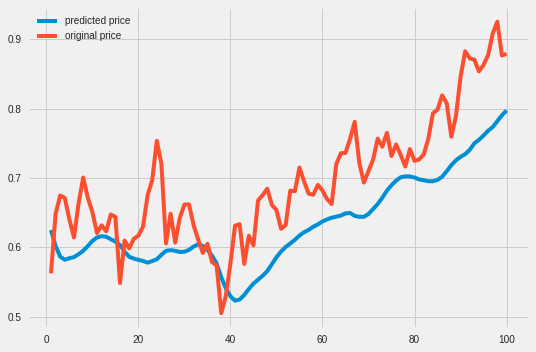

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 75, 50)            10600     
_________________________________________________________________
dropout_38 (Dropout)         (None, 75, 50)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 75, 50)            20200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 75, 50)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (

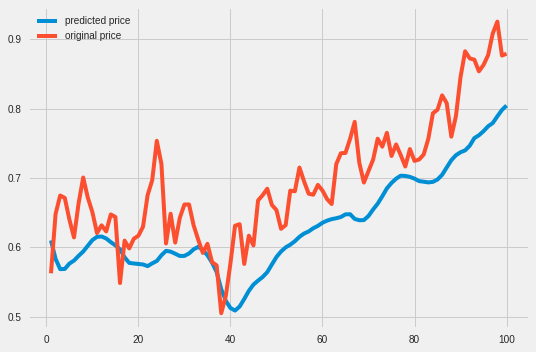

Time stamp: 20
X train shape: (635, 20, 2), y_train shape: (635,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 20, 80)            26560     
_________________________________________________________________
dropout_41 (Dropout)         (None, 20, 80)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 20, 80)            51520     
_________________________________________________________________
dropout_42 (Dropout)         (None, 20, 80)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_43 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_18 (

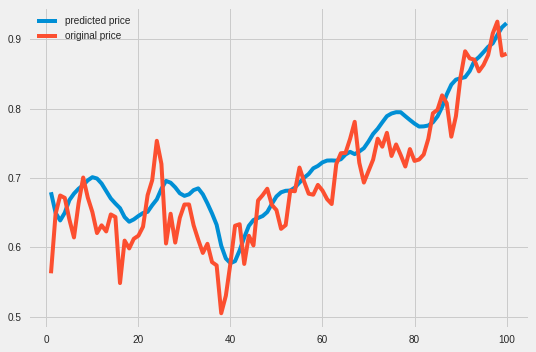

Time stamp: 50
X train shape: (605, 50, 2), y_train shape: (605,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 50, 80)            26560     
_________________________________________________________________
dropout_44 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 50, 80)            51520     
_________________________________________________________________
dropout_45 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_46 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_19 (

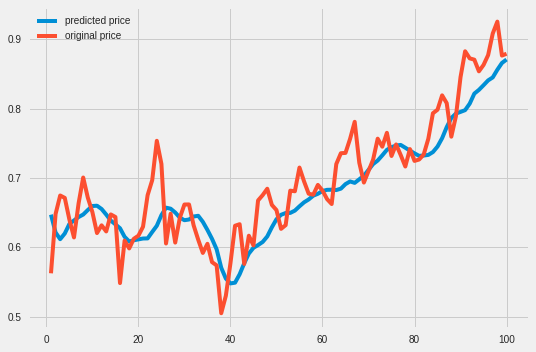

Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 75, 80)            26560     
_________________________________________________________________
dropout_47 (Dropout)         (None, 75, 80)            0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 75, 80)            51520     
_________________________________________________________________
dropout_48 (Dropout)         (None, 75, 80)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_49 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_20 (

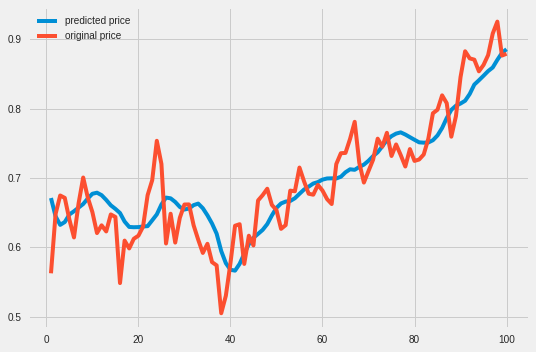

In [0]:
for num_layers in [2, 3]:
    for num_cells in [30, 50, 80]:
        for time_step in [20, 50, 75]:
            run_model(training_set_scaled, num_layers, num_cells, time_step)

## Question 1-2
## HMM

In [0]:
def run_hmm(number_of_hidden_states, time_step):
    predicted = []
    actual = []

    i = 753
    model = hmm.GaussianHMM(
        n_components=number_of_hidden_states,
        covariance_type='full',
        init_params='stmc')
    while (i > 653):
        test_data = training_set_scaled[i]
        train_data = training_set_scaled[:i, :][::-1]
        model.fit(train_data)

        curr_likelihood = model.score(train_data[0:time_step - 1, :])
        past_likelihood = []
        iters = 1
        while iters < len(train_data) / time_step - 1:
            past_likelihood = np.append(
                past_likelihood,
                model.score(train_data[iters:iters + time_step - 1, :]))
            iters = iters + 1
        absolute_liklehood = np.absolute(past_likelihood - curr_likelihood)
        likelihood_diff_i = np.argmin(absolute_liklehood)
        predicted_change = train_data[likelihood_diff_i, :] - train_data[
            likelihood_diff_i + 1, :]
        predicted.append(test_data + predicted_change)
        actual.append(test_data)
        i -= 1
    predicted = np.array(predicted)[:, 0]
    actual = np.array(actual)[:, 0]
    plt.plot(predicted, "-D", label="predicted")
    plt.plot(actual, "-D", label="actual")
    print(
        "Number of cells: {0}, time_step: {1}, Mean square error :{2}".format(
            number_of_hidden_states, time_step,
            mean_squared_error(predicted, actual)))
    plt.legend(loc="best")
    plt.show()
    return predicted

Number of cells: 4, time_step: 20, Mean square error :0.0021543818825632585


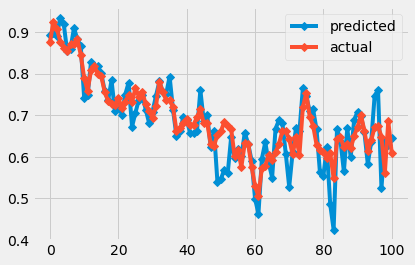

Number of cells: 4, time_step: 50, Mean square error :0.0012167022992299222


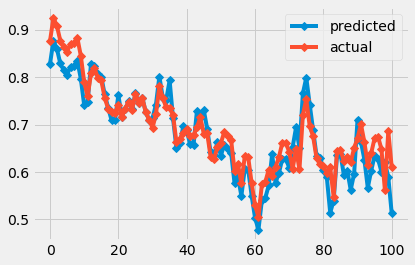

Number of cells: 4, time_step: 75, Mean square error :0.0012063087101210133


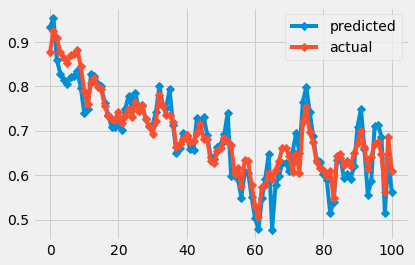

Number of cells: 8, time_step: 20, Mean square error :0.0013883350089383948


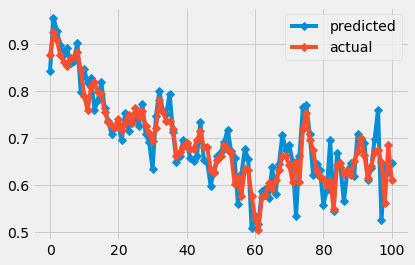

Number of cells: 8, time_step: 50, Mean square error :0.0013839115099009887


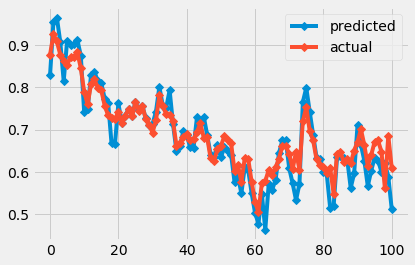

Number of cells: 8, time_step: 75, Mean square error :0.001140114565456546


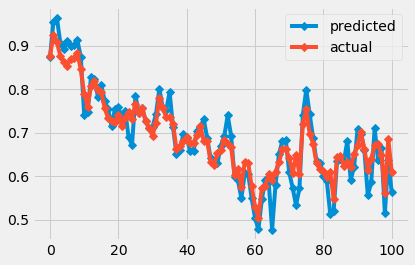

Number of cells: 12, time_step: 20, Mean square error :0.0011778827791529163


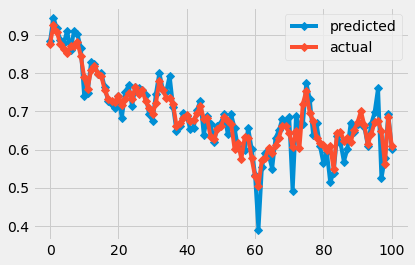

Number of cells: 12, time_step: 50, Mean square error :0.0012098697964796465


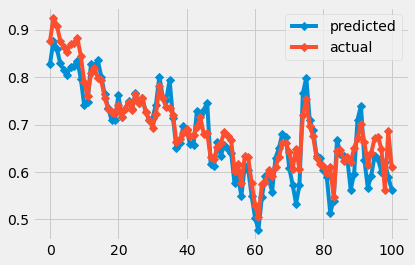

Number of cells: 12, time_step: 75, Mean square error :0.000950920585808581


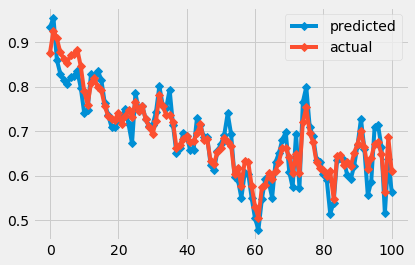

In [0]:
for number_of_hidden_states in [4, 8, 12]:
    for time_step in [20, 50, 75]:
        run_hmm(number_of_hidden_states, time_step)

## Question 1-3

Number of cells: 12, time_step: 75, Mean square error :0.001668035954166667
Time stamp: 75
X train shape: (580, 75, 2), y_train shape: (580,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75, 80)            26560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 80)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 75, 80)            51520     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 80)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         


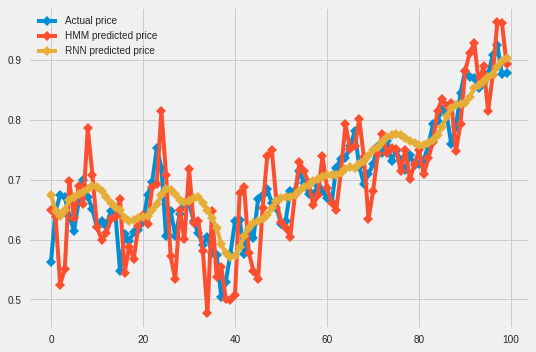

In [20]:
hmm_predicted_price = run_hmm(12, 75)[::-1]
rnn_predicted_price = run_model(training_set_scaled, 3, 80, 75)
actual_price = training_set_scaled[-100:, 0]
plt.plot(actual_price, "-D", label="Actual price")
plt.plot(hmm_predicted_price, "-D", label="HMM predicted price")
plt.plot(rnn_predicted_price, "-D", label="RNN predicted price")
plt.legend(loc="best")
plt.show()

## Question 2

In [54]:
prob_emmision = {
    'E': {
        'A': 0.25,
        'C': 0.25,
        'G': 0.25,
        'T': 0.25
    },
    '5': {
        'A': 0.05,
        'C': 0,
        'G': 0.95,
        'T': 0
    },
    'I': {
        'A': 0.4,
        'C': 0.1,
        'G': 0.1,
        'T': 0.4
    }
}

In [55]:
prob_transition = {
    '^': {
        'E': 1
    },
    'E': {
        'E': 0.9,
        '5': 0.1
    },
    '5': {
        'I': 1
    },
    'I': {
        'I': 0.9,
        '$': 0.1
    }
}

In [56]:
sequence = "CTTCATGTGAAAGCAGACGTAAGTCA"
state_path = "EEEEEEEEEEEEEEEEEE5IIIIIII$"

In [57]:
prob = 1
for i in range(len(sequence)):
    s0 = state_path[i]
    s1 = state_path[i + 1]
    n = sequence[i]
    e = prob_emmision[s0][n]
    t = prob_transition[s0][s1]
    prob = prob * e * t
print(prob)

1.2546466609343717e-18


In [58]:
np.log(prob)

-41.21967768602254